<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#대량의-Coarse-Point-Label-모아보기" data-toc-modified-id="대량의-Coarse-Point-Label-모아보기-1">대량의 Coarse Point Label 모아보기</a></span><ul class="toc-item"><li><span><a href="#눈-이미지-얻기" data-toc-modified-id="눈-이미지-얻기-1.1">눈 이미지 얻기</a></span></li><li><span><a href="#눈동자-찾기" data-toc-modified-id="눈동자-찾기-1.2">눈동자 찾기</a></span></li></ul></li><li><span><a href="#키포인트-검출-딥러닝-모델-만들기" data-toc-modified-id="키포인트-검출-딥러닝-모델-만들기-2">키포인트 검출 딥러닝 모델 만들기</a></span></li></ul></div>

# 대량의 Coarse Point Label 모아보기
## 눈 이미지 얻기
- 얼굴과 랜드마크를 검출하고, 랜드마크를 이용해서 눈 위치만 crop합니다.

In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib

(450, 800, 3)


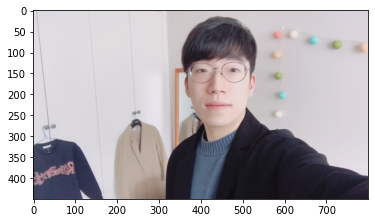

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/images/image.png'
img = cv2.imread(img_path)
print (img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

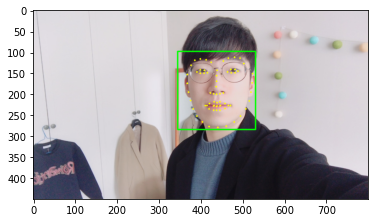

In [3]:
# 얼굴과 랜드마크를 검출합니다.
img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
dlib_model_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(dlib_model_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_rgb, point, 2, (255, 255, 0), -1) # yellow

plt.imshow(img_rgb)
plt.show()

In [4]:
# 랜드마크를 이용해서 눈 위치만 crop합니다.
def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()
    
    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl
    
    ### if eye size is small
    # landmark의 오차로 눈을 검출하기 어려울 수 있으므로 적당한 margin 값 설정
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 6
    
    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

(20, 31, 3)


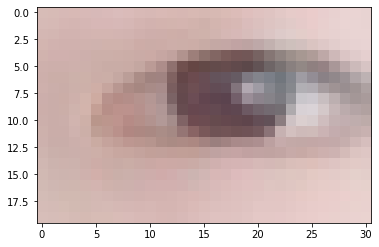

In [5]:
img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

print (img_left_eye.shape)
plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
plt.show()

## 눈동자 찾기
- 눈 이미지를 low pass filter를 이용해서 smoothing 합니다. (bilateralFilter 사용)
- 1차원 값으로 누적시킨 후 y 축 기준으로 최대값을 찾아서 center_y 좌표를 먼저 얻어냅니다.
- x축은 1차원 max point를 기준으로 mean shift를 수행합니다. 양 끝단에 수렴하는 예외를 처리한 후 결과를 출력합니다.

In [6]:
# 눈 중심을 찾는 함수 만들기
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]

    # smoothing
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1
    
    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1
    
    return [center_x, center_y]

In [7]:
# 왼쪽, 오른쪽 두 눈 이미지에 대해 위 함수들을 수행합니다.
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

In [8]:
# 결과를 뽑아보면 아래와 같은 좌표를 얻을 수 있습니다.
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

(16, 8) (16, 8) (20, 31) (20, 31)


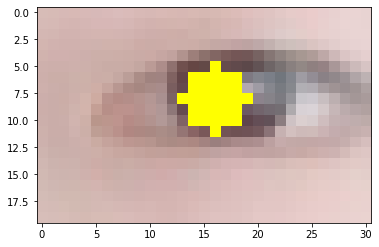

In [9]:
# 이미지로 뽑아서 오른쪽 눈을 보겠습니다.
show = img_right_eye.copy()
    
show = cv2.circle(show, (right_center_x, right_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

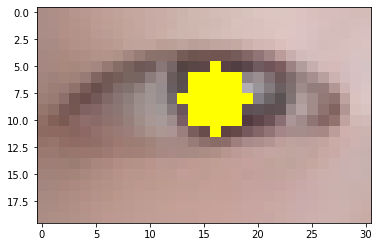

In [10]:
# 왼쪽 눈도 확인해 보겠습니다.
show = img_left_eye.copy()
    
show = cv2.circle(show, (left_center_x, left_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

# 키포인트 검출 딥러닝 모델 만들기
- 더 나은 성능을 위해 대량의 coarse한 라벨을 수집한 뒤, 딥러닝 모델을 개선해 나가는 방법을 사용합니다.
- tensorflow_hub에서 ImageNet으로 학습된 모델을 가지고 와서 눈동자 위치를 학습시킵니다.

In [11]:
# !pip install tensorflow_hub # 설치되어 있지 않은 경우 주석 해제
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [12]:
# tensorflow_hub 에서 ResNet의 특성 추출기 부분을 백본으로 사용합니다.
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(80,120,3))

In [13]:
# 좌표를 학습할 수 있도록 Dense 레이어를 추가합니다.
num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________
